In [4]:
import os
import math
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [6]:
#reaction_mechanism_name, fuel = 'LiDryer', 'H2:1.0'
reaction_mechanism_name, fuel = 'gri30', 'CH4:1.0'
reaction_mechanism = f'../mechanisms/{reaction_mechanism_name}.yaml'

gas = ct.Solution(reaction_mechanism)
gas.transport_model='Mix'

In [7]:
# Define mixture and integration data
phi= 1.0
p  = 1.0    # atm
# p  = 50.0   # atm
T0 = 1100   # K

tFinal = 0.3   # s
dt     = 1e-4  # s

tign=2.0590e-01 s, Tign= 1752.003 K

1752.003047762521K 0.20589999999999364
tAfterIgn = 2.000e-02 s,   timeStep= 2258 


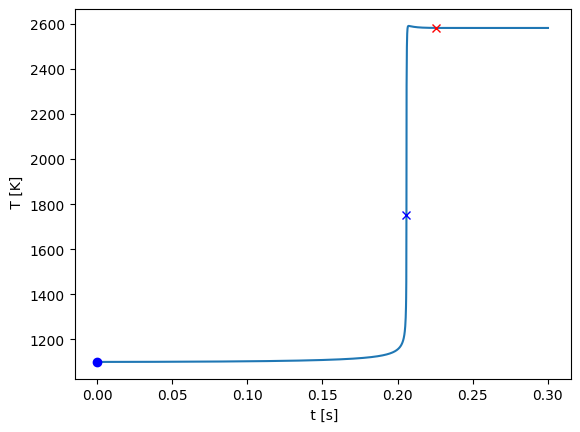

In [8]:
from ruamel.yaml import YAML, scalarstring
yaml=YAML()
yaml.default_flow_style = False

# Initial condition --------------------------------------------------------
gas.set_equivalence_ratio(phi, fuel , 'O2:0.21, N2:0.79')
gas.TP = T0, p*ct.one_atm
#print(gas.species_names)
P = gas.P

# Integrate the constant pressure homogeneous reactor ----------------------
r   = ct.IdealGasConstPressureReactor(gas)
sim = ct.ReactorNet([r])

nst = 0
time = 0.0
tt = []     # time [s]
TT = []     # temperature [K]
XX = []     # mole fractions
YY = []     # mass fractions

tt.append(time)
TT.append(T0)
XX.append(gas.X)
YY.append(gas.Y)

while time<tFinal:
    time = time + dt
    sim.advance(time) # CVODE
    tt.append(time)   # time [s]
    TT.append(r.T)    # temperature [K]
    YY.append(r.Y)    # mass fractions
    gas.Y = r.Y
    XX.append(gas.X)  # mole fractions
    nst = nst + 1

# State 1: Initial state to test initiation reactions ------------------------
with open(f'{reaction_mechanism_name}.initial', 'w') as f: 
# with open(f'{reaction_mechanism_name}.initial.highP', 'w') as f: 
    yaml.dump({
    'temperature': TT[0], 
    'pressure':    gas.P, 
    'X': dict(zip([scalarstring.DoubleQuotedScalarString(name) for name in gas.species_names], XX[0].tolist()))
}, f)


# State 2: Ignition ----------------------------------------------------------

f      = UnivariateSpline(tt[:nst], TT[:nst])
dTdt   = f.derivative()           # dT/dt
ignStep = np.argmax(dTdt(tt))
ignTime = tt[ignStep]
Tign    = TT[ignStep]
print('tign=%.4e s, Tign= %.3f K\n' % (ignTime, Tign) )
print(f'{Tign:=}K {ignTime:=}')

with open(f'{reaction_mechanism_name}.ignition', 'w') as f: 
# with open(f'{reaction_mechanism_name}.ignition.highP', 'w') as f: 
    yaml.dump({
    'temperature': Tign,
    'pressure': gas.P,
    'X': dict(zip([scalarstring.DoubleQuotedScalarString(name) for name in gas.species_names],XX[ignStep].tolist()))
}, f)
    
    
# State 3: post ignition ----------------------------------------------------

tAfterIgn = 20e-3
stepAfterIgn = min( int((ignTime + tAfterIgn)/dt), int(tFinal/dt) )
print('tAfterIgn = %.3e s,   timeStep= %d ' % (tAfterIgn, stepAfterIgn) )

with open(f'{reaction_mechanism_name}.final', 'w') as f: 
# with open(f'{reaction_mechanism_name}.final.highP', 'w') as f: 
    yaml.dump({
    'temperature': TT[stepAfterIgn], 
    'pressure': gas.P, 
    'X': dict(zip([scalarstring.DoubleQuotedScalarString(name) for name in gas.species_names],XX[stepAfterIgn].tolist()))
}, f)

# visual check
plt.plot(tt, TT, '-')
plt.plot(tt[0], TT[0], 'bo')
plt.plot(tt[ignStep], TT[ignStep], 'bx')
plt.plot(tt[stepAfterIgn], TT[stepAfterIgn], 'rx')
plt.xlabel(' t [s]')
plt.ylabel(' T [K]')
plt.show()


In [5]:
# thermodynamic properties
cp = []   # [J/kmol/K]
Hk = []

gas.TPX = T0, P, XX[0]
cp.append(gas.partial_molar_cp)
Hk.append(gas.partial_molar_enthalpies)

gas.TPX = TT[ignStep], P, XX[ignStep]
cp.append(gas.partial_molar_cp)
Hk.append(gas.partial_molar_enthalpies)

gas.TPX = TT[stepAfterIgn], P, XX[stepAfterIgn]
cp.append(gas.partial_molar_cp)
Hk.append(gas.partial_molar_enthalpies)

print("----cp [J/kmol/K]----")
for name in gas.species_names: 
    idx = gas.species_index(name)
    print('%-15s  %+.15e  %+.15e  %+.15e' % (name, cp[0][idx], \
                                                   cp[1][idx], \
                                                   cp[2][idx]) )
print("----Hk [J/kmol] ----")    
for name in gas.species_names: 
    idx = gas.species_index(name)
    print('%-15s  %+.15e  %+.15e  %+.15e' % (name, Hk[0][idx], \
                                                   Hk[1][idx], \
                                                   Hk[2][idx]) )

----cp [J/kmol/K]----
H2               +3.057723197362948e+04  +3.331457248350362e+04  +3.607285562808500e+04
H                +2.078615653360310e+04  +2.078615653189034e+04  +2.078615653490073e+04
O                +2.090315461378404e+04  +2.082984883024328e+04  +2.086305342316002e+04
O2               +3.528549947731422e+04  +3.722070811968867e+04  +3.908836592138767e+04
OH               +3.117396092405957e+04  +3.392064125508298e+04  +3.625366232073643e+04
H2O              +4.261609418008738e+04  +4.972830311126374e+04  +5.519273293009176e+04
HO2              +4.864417687075536e+04  +5.411951652195380e+04  +5.872524960124817e+04
H2O2             +6.414909520305072e+04  +7.194450225038735e+04  +7.709216217973034e+04
C                +2.079028105220190e+04  +2.086751469323008e+04  +2.129669279518362e+04
CH               +3.303405238622471e+04  +3.729845533264078e+04  +4.058594359459253e+04
CH2              +4.581370758872305e+04  +5.136383252782622e+04  +5.459373054429219e+04
CH2(S)    

In [9]:
#  species net production rates 
netProdRates = []
rxnRates = []

gas.TPX = T0, P, XX[0]
netProdRates.append(gas.net_production_rates)
rxnRates.append(gas.net_rates_of_progress)

gas.TPX = TT[ignStep], P, XX[ignStep]
netProdRates.append(gas.net_production_rates)
rxnRates.append(gas.net_rates_of_progress)

gas.TPX = TT[stepAfterIgn], P, XX[stepAfterIgn]
netProdRates.append(gas.net_production_rates)
rxnRates.append(gas.net_rates_of_progress)

for name in gas.species_names: 
    idx = gas.species_index(name)
    print('%-15s  %+.15e  %+.15e  %+.15e' % (name, netProdRates[0][idx], \
                                                   netProdRates[1][idx], \
                                                   netProdRates[2][idx]) )

H2               +0.000000000000000e+00  +3.481887693637525e+00  +6.097758510953615e-06
H                +3.288373912842224e-09  +7.475624326159941e-01  -2.475392649933266e-06
O                +7.807622234555393e-15  +1.666856688769236e-01  -6.263184741895375e-06
O2               -1.177478580049799e-06  -1.119117666926873e+01  -4.168250746811123e-05
OH               +0.000000000000000e+00  +4.650665006281999e-01  -1.630409798741111e-05
H2O              +0.000000000000000e+00  +1.220994380043672e+01  +3.293550793257196e-06
HO2              +1.177478572434412e-06  -2.561895682724355e-02  -8.115488026412645e-09
H2O2             +0.000000000000000e+00  -1.987969312101125e-03  -3.082359656538604e-10
C                +0.000000000000000e+00  +3.490904668161561e-05  -6.132718575475240e-17
CH               +0.000000000000000e+00  +7.511030061988703e-04  -3.406880815901834e-18
CH2              +0.000000000000000e+00  +2.186487731667868e-02  -3.174883287554850e-19
CH2(S)           +0.000000000000

In [10]:
# individual reaction rates
for ir in range(gas.n_reactions): 
    print('%3d   %-35s  %+.15e  %+.15e  %+.15e' % (ir, gas.reaction_equation(ir), \
                                                 rxnRates[0][ir], \
                                                 rxnRates[1][ir], \
                                                 rxnRates[2][ir]) )


  0   2 O + M <=> O2 + M                   -1.922345949111911e-16  +2.891711432189180e-06  +2.171196243871661e-09
  1   H + O + M <=> OH + M                 +0.000000000000000e+00  +3.326228892875930e-05  +9.480164368965132e-09
  2   H2 + O <=> H + OH                    +0.000000000000000e+00  +1.223163147770938e+00  -2.090430928802789e-06
  3   HO2 + O <=> O2 + OH                  +0.000000000000000e+00  +4.479622701330309e-02  +2.020245506908352e-08
  4   H2O2 + O <=> HO2 + OH                +0.000000000000000e+00  +3.646753792438944e-04  +5.954190401358597e-10
  5   CH + O <=> CO + H                    +0.000000000000000e+00  +2.741216711631158e-04  -1.731117559831129e-13
  6   CH2 + O <=> H + HCO                  +0.000000000000000e+00  +2.175754664858505e-02  -1.188312981145347e-12
  7   CH2(S) + O <=> CO + H2               +0.000000000000000e+00  +4.592692425562992e-04  -2.114194132635084e-14
  8   CH2(S) + O <=> H + HCO               +0.000000000000000e+00  +4.592692425318177e-0

In [11]:
# transport properties
gas.TPX = T0, P, XX[0]
print('cond =', gas.thermal_conductivity)
print('visc =', gas.viscosity)
print('rho*diff =', gas.density*gas.mix_diff_coeffs_mole)

cond = 0.08322367216413123
visc = 4.4288965449266004e-05
rho*diff = [2.10415889e-04 3.49038121e-04 9.03333481e-05 5.91349229e-05
 8.86311447e-05 7.57793576e-05 5.86369593e-05 5.82411258e-05
 8.49520845e-05 9.66225777e-05 6.60905314e-05 6.60905314e-05
 6.46123647e-05 6.40172798e-05 5.82124595e-05 4.72449744e-05
 5.06065353e-05 5.01922488e-05 4.92650369e-05 4.92650369e-05
 4.91101093e-05 4.97796319e-05 4.92737319e-05 4.88007708e-05
 4.86906310e-05 4.47532117e-05 4.43875778e-05 7.28534750e-05
 4.26551442e-05 4.26551442e-05 8.06461645e-05 9.51512642e-05
 9.32027572e-05 7.13661471e-05 5.68773566e-05 5.77353197e-05
 5.12929783e-05 4.66269674e-05 5.85102574e-05 5.73158404e-05
 5.02220454e-05 4.97655487e-05 7.28520503e-05 4.68324764e-05
 4.68324764e-05 4.68324764e-05 4.70510850e-05 6.01542171e-05
 3.46329750e-05 3.44783195e-05 4.24571216e-05 4.22672709e-05
 5.72096513e-05]


In [12]:
# Save cantera output for CI

from pathlib import Path

def write_module(module_name, content):
    open(f'{module_name}','w').write(content.replace('+-','-'))

In [13]:
#-------------  Initial condition ----------------

gas.TPX = T0, P, XX[0]


write_module(f'{reaction_mechanism_name}.initial.cantera',
# write_module(f'{reaction_mechanism_name}.initial.highP.cantera',
f"""{' '.join(gas.species_names)}
{' '.join(repr(w*1e-3) for w in gas.molecular_weights)}
{repr(T0)}
{repr(P)}
{' '.join(repr(x) for x in XX[0])}
{repr(gas.density_mass)}
{repr(gas.cp_mole*1e-3)}
{' '.join(repr(c*1e-3) for c in gas.partial_molar_cp)}
{' '.join(repr(d*1e3) for d in gas.net_production_rates)}
{repr(gas.heat_release_rate)}
{repr(gas.thermal_conductivity)}
{repr(gas.viscosity)}
{' '.join(repr(gas.density_mass*diffusivity) for diffusivity in gas.mix_diff_coeffs)}
""")

In [14]:
#-------------- Ignition ------------------

gas.TPX = TT[ignStep], P, XX[ignStep]

write_module(f'{reaction_mechanism_name}.ignition.cantera',
# write_module(f'{reaction_mechanism_name}.ignition.highP.cantera',
f"""{' '.join(gas.species_names)}
{' '.join(repr(w*1e-3) for w in gas.molecular_weights)}
{repr(TT[ignStep])}
{repr(P)}
{' '.join(repr(x) for x in XX[ignStep])}
{repr(gas.density_mass)}
{repr(gas.cp_mole*1e-3)}
{' '.join(repr(c*1e-3) for c in gas.partial_molar_cp)}
{' '.join(repr(d*1e3) for d in gas.net_production_rates)}
{repr(gas.heat_release_rate)}
{repr(gas.thermal_conductivity)}
{repr(gas.viscosity)}
{' '.join(repr(gas.density_mass*diffusivity) for diffusivity in gas.mix_diff_coeffs)}
""")

In [15]:
#-------------  Post ignition ------------

gas.TPX = TT[stepAfterIgn], P, XX[stepAfterIgn]

write_module(f'{reaction_mechanism_name}.final.cantera',
# write_module(f'{reaction_mechanism_name}.final.highP.cantera',
f"""{' '.join(gas.species_names)}
{' '.join(repr(w*1e-3) for w in gas.molecular_weights)}
{repr(TT[stepAfterIgn])}
{repr(P)}
{' '.join(repr(x) for x in XX[stepAfterIgn])}
{repr(gas.density_mass)}
{repr(gas.cp_mole*1e-3)}
{' '.join(repr(c*1e-3) for c in gas.partial_molar_cp)}
{' '.join(repr(d*1e3) for d in gas.net_production_rates)}
{repr(gas.heat_release_rate)}
{repr(gas.thermal_conductivity)}
{repr(gas.viscosity)}
{' '.join(repr(gas.density_mass*diffusivity) for diffusivity in gas.mix_diff_coeffs)}
""")